# Data Science Assesment

Tasks:
1. Create a TensorFlow model that performs product classification based on the available
categories. [Link to the Dataset]
2. Try out a few base models and save your models in .h5 format. Feel free to check out
the TensorFlow Documentation Page.
3. Perform Transfer Learning on your existing model, you can use this pre-trained model for
the same which is trained on the fashionMNIST dataset.
4. Plot graphs for all the models that you try and save the results into a document file.


## Imports

In [ ]:
!pip install PyDrive

In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 394.3MB 41kB/s 


In [ ]:
!pip install -q keras

In [ ]:
import keras
from keras.models import load_model
from keras.layers import Input, Lambda, Dense, Flatten, Conv2D, BatchNormalization, Dropout, MaxPooling2D
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from glob import glob

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
import os
import datetime as dt
import six
import numpy as np
import h5py
import matplotlib.pyplot as plt
import cv2

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

## Connect the google drive to the environment

In [ ]:
# Load the Drive helper and mount
#from google.colab import drive

# This will prompt for authorization.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Import the Productos.zip file and unzip it

In [ ]:
#2.1 Get the file
downloaded = drive.CreateFile({'id':'1qTc4DWUihozI4xNI_B4XP2E-LXcgdVET'}) # replace the id with id of file you want to access
downloaded.GetContentFile('Productos.zip') 

In [ ]:
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/content': ['.config', 'adc.json', 'drive', 'Productos.zip', 'sample_data']


In [ ]:
from zipfile import ZipFile
file_name = "Productos.zip"

with ZipFile(file_name, 'r') as proj:
  proj.extractall()
  print('Done')

Done


## Prepare Dataset

The first step to prepare the Dataset is to split the current folder with the images in their categories into the following architecture.

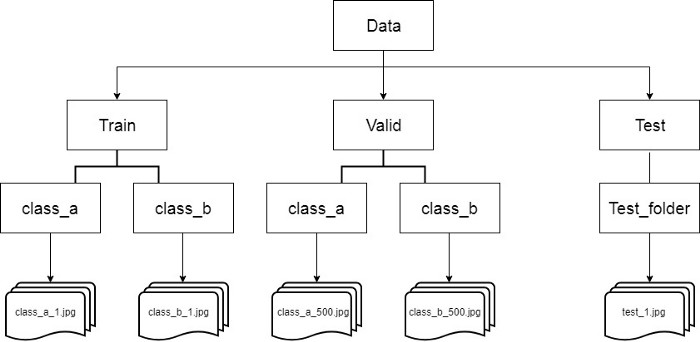

As shown in the figure above, we need to have the Data split between 3 folders(Train, Valid, Test). The Train and the Valid get divided in 29 sub-folders, one for each category.

In [ ]:
pip install split-folders

In [ ]:
pip install split-folders tqdm

In [ ]:
import splitfolders

In [ ]:
splitfolders.ratio("/content/drive/MyDrive/Proyecto ropa/Colab Notebooks/ROPA", output="output", seed=1337, ratio=(.8, .1, .1), group_prefix=None) # default values

Copying files: 9394 files [47:20,  3.31 files/s]


In [ ]:
train_path = "/content/output/train"
test_path = "/content/output/test"
val_path = "/content/output/val"

## Preparing the new Dataset

The images are rescaled and passed through a process of image augmentation for a better fitting of the model. The image size was set to (50, 50, 3) meaning that it has a height and width of 50 pixels and 3 channels, rgb. We are working with channel last default.

In [ ]:
IMG_SIZE = (50, 50)

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Proyecto ropa/output/train", 
    target_size = (50,50),
    color_mode = 'rgb',
    batch_size = 16,
    class_mode = 'categorical',
    shuffle = True,
    seed = 42)

valid_generator = valid_datagen.flow_from_directory(
    directory=r"/content/drive/MyDrive/Proyecto ropa/output/val",
    target_size=(50, 50),
    color_mode="rgb",
    batch_size=16,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_set = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Proyecto ropa/output/test',
    target_size = (50, 50),
    batch_size = 1,
    shuffle = False,
    seed = 42,
    class_mode = None)

Found 7502 images belonging to 29 classes.
Found 928 images belonging to 29 classes.
Found 964 images belonging to 29 classes.


This is how the modified images look like, and how the model will use them for fitting.

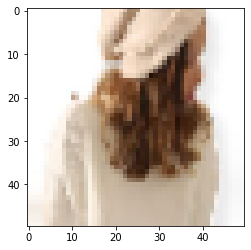

In [ ]:
img = plt.imshow(training_set[2][0][0])

def norm_input(x): return (x-mean_px)/std_px


## Compile and train the model



For the model we used a Sequential model as all the layers will be stacked with each one having exactly one input tensor and one output tensor. The model consists of a series of Conv2D layers which creates convolution kernels for detecting features and patterns in the images. Then a BatchNormalization that standarizes the inputs and reduces the amount of epochs needed for the training of the model. Then the MaxPooling2D layer is used to summarize the average presence of a feature and the most activated presence of a feature respectively.
Finally a Flatten layer is include to change the dimension of the outpus followed by some Dense layers with 512 neurons. In between the Dense layers a Dropout of 50% is included to help prevent overfitting of the model. Finally, the last Dense layer has an output of 29 neurons, that represent each of the categories if the Dataset, and an activation function softmax for a probability distribution of the output.

In [ ]:
STEP_SIZE_TRAIN=training_set.n//training_set.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model = Sequential()

Lambda(norm_input, input_shape=(50, 50, 3)),
model.add(Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=(50, 50, 3), strides=(2, 2)))
model.add(Conv2D(32, (5, 5), activation='relu', padding='same', strides=(2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(29, activation='softmax'))


model.compile(optimizer = 'adam', loss = 'categorical_crossentropy' , metrics = ['accuracy'])

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
check = ModelCheckpoint("check.h5", monitor='val_loss',save_best_only=True)

#model = Model(inputs=input, outputs=output)
history = model.fit_generator(generator=training_set,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=100,
                    callbacks=[check, es]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
  3/468 [..............................] - ETA: 29:13 - loss: 5.2563 - accuracy: 0.0799

KeyboardInterrupt: ignored

In [ ]:
model.save('history.h5')

## Model Summary

Plot the Accuracy and Loss with the Epochs to visualize the evolution of the model.

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.savefig('/content/drive/MyDrive/Proyecto ropa')

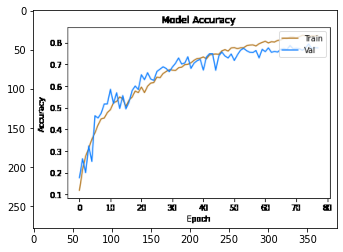

In [ ]:
import cv2

img = cv2.imread("/content/drive/MyDrive/Proyecto ropa/Colab Notebooks/Accuracy.png")
#img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

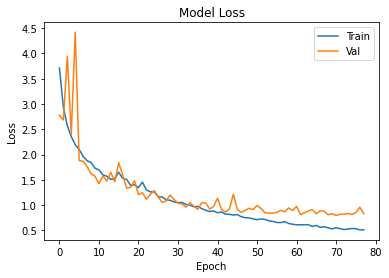

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()
plt.savefig('/content/drive/MyDrive/Proyecto ropa')

Save the model in the Drive and download it to the local storage. Display the summary of the architecture of the model with the layers that construct it.

In [ ]:
model.save('Model.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        25632     
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 64)          0

## Testing of the model

We upload an image from google of a watch through google.colab

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving watch2_test.jfif to watch2_test.jfif


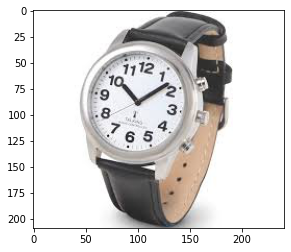

In [ ]:
new_image = plt.imread('watch2_test.jfif')
img = plt.imshow(new_image)


Resize the image to match the input of the model (50, 50, 3)

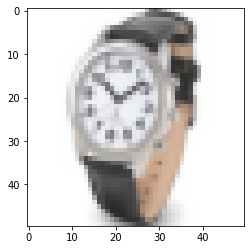

In [ ]:
#Resize the image
from skimage.transform import resize
resized_image = resize(new_image, (50, 50, 3))
img = plt.imshow(resized_image)

Run the model to predict the category of the image given. This results in an array with 29 different slots, the one with the highest value represents the models prediction.

In [ ]:
#get the models predictions
predictions = model.predict(np.array([resized_image]))
#Show the predictions
predictions

array([[1.4344568e-04, 2.5195770e-06, 1.4853532e-06, 7.7916161e-07,
        1.0111430e-06, 3.6681697e-06, 8.2539520e-07, 1.3316562e-04,
        2.2473587e-03, 1.1742073e-05, 1.1972271e-05, 1.7467944e-07,
        2.1857915e-05, 2.9567536e-06, 3.8914714e-06, 4.0251977e-04,
        1.7769552e-06, 2.8748281e-04, 3.9187979e-04, 4.9229948e-07,
        5.0719427e-03, 1.5540425e-04, 3.9034580e-06, 3.1401171e-06,
        2.3516766e-05, 8.0819736e-04, 7.9070478e-06, 9.3112059e-05,
        9.9016190e-01]], dtype=float32)

Sort the array from highest to lowest and define what category is the one with the highest probability. In this case it corresponds to the category 28, which is in fact wristwatch. The prediction worked!

In [ ]:
#Sort the predictions from leasto to greatest
list_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
x = predictions

for i in range(29):
  for j in range(29):
    if x[0][list_index[i]] > x[0][list_index[j]]:
      temp = list_index[i]
      list_index[i] = list_index[j]
      list_index[j] = temp

#Show the sorted labels in order
print(list_index)


[28, 20, 8, 25, 15, 18, 17, 21, 0, 7, 27, 24, 12, 10, 9, 26, 22, 14, 5, 23, 13, 1, 16, 2, 4, 6, 3, 19, 11]


## Transfer Learning

In this section we use a pretrained model called (95Model.h5) that was trained using the Fashion-MNIST Dataset. This Dataset consists of 60000 images with a size of (28, 28, 1) meaning that we have to resize our own Dataset and transform it to grayscale, 1 channel. 

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Proyecto ropa/Colab Notebooks/history.h5')


In [ ]:
model_new = load_model("/content/drive/MyDrive/Proyecto ropa/Colab Notebooks/91Model.h5")

A summary of the given model is shown below.

In [ ]:
model_new.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               819456    
_________________________________________________________________
dense_16 (Dense)             (None, 10)               

The model consists of 7 layers, with only 2 Conv2D layers. The model was trained to classify between 10 different categories. As our task for the model needs to classify for our given 29 categories, we need to take out the last two Dense layers and continue the model from there. We also set all the layers to trainable, this step is just to make sure they are not freezed.

In [ ]:
model.trainable = True

As we are not going to need the last layer we just call the pop() function twice to delete the last two layers of the model.

In [ ]:
#model_new.pop()

In [ ]:
model_new.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 3200)              0         
Total params: 74,496
Trainable params: 0
Non-trainable params: 74,496
_________________________________________________________________


Now the last layer is the Flatten. The next step is to modify our own Dataset so that the images will have a size of (28, 28, 1). We also run the images through a ImageDataGenerator to make small modifications to the images helping the model to achieve a better fit.

In [ ]:
def to_grayscale(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return image

model_new.

In [ ]:
'''def myFunc(image):
    image = np.array(image)
    converted_img = rgb_to_cmyk(image)
    converted_img /= 255
    return converted_img'''

def to_grayscale(image):
  image = tf.image.rgb_to_grayscale(image)
  return image

#def to_grayscale(image):
  #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  #return image  

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   preprocessing_function=None)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   preprocessing_function=None)

test_datagen = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=None)

training_set_2 = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Proyecto ropa/output/train",
      target_size = (28, 28),
      color_mode ='grayscale',
      batch_size = 16,
      class_mode = 'categorical',
      shuffle = True,
      seed = 42
)

valid_generator_2 = valid_datagen.flow_from_directory(
    directory=r"/content/drive/MyDrive/Proyecto ropa/output/val",
    target_size=(28, 28),
    color_mode='grayscale',
    batch_size=16,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_set_2 = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Proyecto ropa/output/test',
     target_size = (28, 28),
     batch_size = 1,
     shuffle = False,
     seed = 42,
     class_mode = None)

Found 7502 images belonging to 29 classes.
Found 928 images belonging to 29 classes.
Found 964 images belonging to 29 classes.


TypeError: ignored

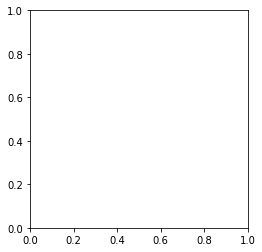

In [ ]:
img2 = plt.imshow(training_set_2[0][0][0], cmap='gray')

## Constructing and Training the new Model

We add a few layers at the end of the given Model, making sure the last layer has 29 neurons as output. We also freeze all the layers from the given Model so that we train the new layers, and the fitting is faster.

In [ ]:
STEP_SIZE_TRAIN1=training_set_2.n//training_set_2.batch_size
STEP_SIZE_VALID1=valid_generator_2.n//valid_generator_2.batch_size

In [ ]:
#cut_model = model_new(weights='imagenet', include_top=False)
#model.save('model_weights.h5')

base_inputs = model_new.layers[0].input
base_outputs = model_new.layers[-1].output
# add a global spatial average pooling layer
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(base_outputs)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(29, activation='softmax')(x)

# this is the model we will train
combined_model = Model(inputs=base_inputs, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in model_new.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
# simple early stopping

es1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
check1 = ModelCheckpoint("check.h5", monitor='val_loss',save_best_only=True)

#model = Model(inputs=input, outputs=output)
savedhistory = combined_model.fit_generator(generator=training_set_2,
                    steps_per_epoch=STEP_SIZE_TRAIN1,
                    validation_data=valid_generator_2,
                    validation_steps=STEP_SIZE_VALID1,
                    epochs=100,
                    callbacks=[check1, es1])


#####combined_model = Sequential()
#####combined_model.add(model_new(include_top=False,
####weights='imagenet'))

NameError: ignored

## Summary and Graphs of new Model with Transfer Learning.

In [ ]:
combined_model.save('Combined.h5')

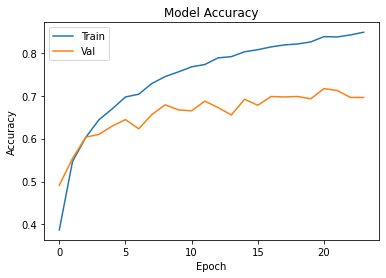

In [ ]:
plt.plot(savedhistory.history['accuracy'])
plt.plot(savedhistory.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

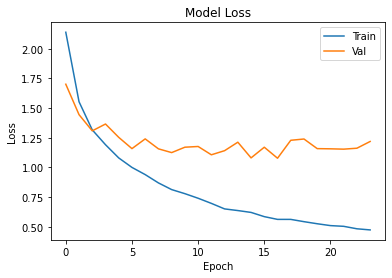

In [ ]:
plt.plot(savedhistory.history['loss'])
plt.plot(savedhistory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()